<a href="https://colab.research.google.com/github/it-ru/cft-cv-project-clip/blob/add-colab-notebook/Laguktin_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final project in CV sprint (CFT "SHIFT" course)
##Theme: natural language query image search (CLIP implementation)
##Student: Evgeniy Lagutkin

##Preparation

Checking CUDA and PyTorch

See information [here](https://github.com/openai/CLIP#usage)

In [1]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 11.1


In [2]:
!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex -qq
!pip install  ipyplot -qq
!pip install ftfy tqdm regex -qq

     |███████████████████████         | 834.1 MB 1.3 MB/s eta 0:04:00tcmalloc: large alloc 1147494400 bytes == 0x55f2ceba0000 @  0x7f07473ce615 0x55f295c584cc 0x55f295d3847a 0x55f295c5b2ed 0x55f295d4ce1d 0x55f295ccee99 0x55f295cc99ee 0x55f295c5cbda 0x55f295cced00 0x55f295cc99ee 0x55f295c5cbda 0x55f295ccb737 0x55f295d4dc66 0x55f295ccadaf 0x55f295d4dc66 0x55f295ccadaf 0x55f295d4dc66 0x55f295ccadaf 0x55f295c5d039 0x55f295ca0409 0x55f295c5bc52 0x55f295ccec25 0x55f295cc99ee 0x55f295c5cbda 0x55f295ccb737 0x55f295cc99ee 0x55f295c5cbda 0x55f295cca915 0x55f295c5cafa 0x55f295ccac0d 0x55f295cc99ee
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:24tcmalloc: large alloc 1434370048 bytes == 0x55f3131f6000 @  0x7f07473ce615 0x55f295c584cc 0x55f295d3847a 0x55f295c5b2ed 0x55f295d4ce1d 0x55f295ccee99 0x55f295cc99ee 0x55f295c5cbda 0x55f295cced00 0x55f295cc99ee 0x55f295c5cbda 0x55f295ccb737 0x55f295d4dc66 0x55f295ccadaf 0x55f295d4dc66 0x55f295ccadaf 0x55f295d4dc66 0x55f295ccadaf 0x55f2

In [42]:
import torch
from torchvision import transforms

import math
import pandas as pd
from random import randint

from pathlib import Path
import os, glob
import sys
from shutil import copy2, make_archive

from tqdm.notebook import tqdm
import numpy as np
import time

from PIL import Image
from IPython.display import display, Image as Img
import ipyplot
from ipyplot import plot_images
import matplotlib.pyplot as plt


print("Torch version:", torch.__version__)

Torch version: 1.7.1+cu110


In [4]:
# Mount GDrive as a folder
# Load the Drive helper and mount
from google.colab import drive, files

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


## Set some config parameters

In [5]:
IMAGES_PATH = '/content/drive/MyDrive/Shift/photos/'
QUERY_IMAGES_PATH = '/content/query_images/' # folder for downloading images
RESULTS_COUNT = 100 # max results for CLIP search
MAX_IMAGES = 8 # max putput images for plot
MIN_SIMILARITY = 2.6 # score threshold

In [6]:
data_cleaned = False

os.chdir("/content")

os.makedirs("features", exist_ok=True) 
os.makedirs(QUERY_IMAGES_PATH, exist_ok=True) 
cur_path = os.getcwd()

# Set the path to the photos
photos_path = Path(IMAGES_PATH) #/ "photos"

# List all JPGs in the folder
photos_files = list(photos_path.glob("*.jpg"))

os.chdir("/content")
features_path = Path(os.path.join(os.getcwd(),"features"))
# Print some statistics
print(f"Photos found: {len(photos_files)}")

Photos found: 5008


RGB
(1125, 1500)
475



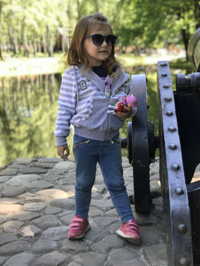


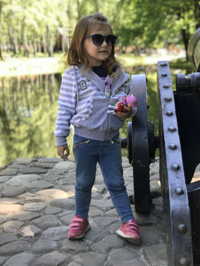

In [7]:
# display a random image
rand_img = randint(0,len(photos_files))
img = Image.open(photos_files[rand_img])
print(img.mode)
print(img.size)
print(rand_img)
plot_images([img], max_images=1, img_width=200, force_b64=True)

In [8]:
# # clean
# check exif corrupt of not rgb

if not data_cleaned:
  for img in tqdm(photos_files):           
      try:
          image = Image.open(img)
          exif_data = image._getexif()     
          if image.mode != 'RGB':
              try:
                  os.remove(img) 
                  print(f"corrupted image {img} deleted")
              except FileNotFoundError as e:
                  print(sys.exc_info()[0])  
                  
      except:
          print(sys.exc_info()[0])
          try:
              os.remove(img) 
              print(f"corrupted image {img} deleted")
          except: 
            print(img,"no image")
           
  data_cleaned = True
  print("dataset is cleaned")

  0%|          | 0/5008 [00:00<?, ?it/s]

dataset is cleaned


In [9]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [10]:
#check drivers
print("Is cuda available: " ,torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Is cuda available:  True


## Dowload and import CLIP model

In [11]:
os.chdir("/content")
if not os.path.isfile(os.path.join(os.getcwd(),"CLIP")):
  !git clone https://github.com/openai/CLIP.git
%cd CLIP
from clip import clip

Cloning into 'CLIP'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 185 (delta 7), reused 14 (delta 4), pack-reused 168
Receiving objects: 100% (185/185), 8.90 MiB | 26.81 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/CLIP


In [12]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [13]:
model, preprocess = clip.load("ViT-B/32", device=device)
os.chdir("/content")

100%|███████████████████████████████████████| 338M/338M [00:18<00:00, 19.1MiB/s]


## Function for plotting founded images

In [14]:
def plt_images(files_list, similarities, request_text, preprocess):
  original_images = []
  images = []
  texts = []
  plt.figure(figsize=(16, 8))
  
  for filename, similarity in zip(files_list[:MAX_IMAGES], similarities[:MAX_IMAGES]):
      name = os.path.basename(filename)
      image = Image.open(filename).convert("RGB")
    
      plt.subplot(2, 4, len(images) + 1)
      plt.imshow(image)
      plt.title(f"{name} (score:{similarity:.2f})")
      plt.xticks([])
      plt.yticks([])

      original_images.append(image)
      images.append(preprocess(image))
      #texts.append(descriptions[name])
  
  plt.tight_layout()
  plt.suptitle(f"Images for query: {request_text}", size=16)
  plt.subplots_adjust(top=0.9)
  plt.show()

In [15]:
# to fp 16 
is_fp16 = False
if is_fp16:
    model.to(device=device).eval().half()
    print("fp16: Enabled")
else:
    model.to(device=device).eval()#.float()

input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [16]:
# Function that computes the feature vectors for a batch of images

def compute_clip_features(photos_batch):
    # Load all the photos from the files
    photos = [Image.open(photo_file) for photo_file in photos_batch]
    
    # Preprocess all photos
    photos_preprocessed = torch.stack([preprocess(photo) for photo in photos]).to(device)

    with torch.no_grad():
        # Encode the photos batch to compute the feature vectors and normalize them
        photos_features = model.encode_image(photos_preprocessed)
        photos_features /= photos_features.norm(dim=-1, keepdim=True)
    # Transfer the feature vectors back to the CPU and convert to numpy
    return photos_features.cpu().numpy()

## Compute and save all features for images

In [17]:
batch_size = 10
batches = math.ceil(len(photos_files) / batch_size)-1

# Process each batch
for i in tqdm(range(batches)):
    batch_ids_path = features_path / f"{i:010d}.csv"
    batch_features_path = features_path / f"{i:010d}.npy"
    batch_files = photos_files[i*batch_size : (i+1)*batch_size]
    batch_features = compute_clip_features(batch_files)
    np.save(batch_features_path, batch_features)
    photo_ids = [photo_file for photo_file in batch_files]
    photo_ids_data = pd.DataFrame(photo_ids, columns=['photo_id'])
    photo_ids_data.to_csv(batch_ids_path, index=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [18]:
# Load all numpy files
features_list = [np.load(features_file) for features_file in sorted(features_path.glob("*.npy"))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
np.save(features_path / "features.npy", features)

# Load all the photo IDs
photo_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])
photo_ids.to_csv(features_path / "photo_ids.csv", index=False)

# Print some statistics
print(f"Photos loaded: {len(photo_ids)}")

def encode_search_query(search_query):
  with torch.no_grad():
    # Encode and normalize the search query using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

  # Retrieve the feature vector from the GPU and convert it to a numpy array
  return text_encoded.cpu().numpy()

def display_photo(photo_id):
  display(Img(photo_id))

Photos loaded: 5000


In [19]:
def find_best_matches(text_features, photo_features, photo_ids, results_count=RESULTS_COUNT):
  # Compute the similarity between the search query and each photo using the Cosine similarity
  similarities = (photo_features @ text_features.T).squeeze(1)
  scores = sorted(similarities,reverse=True)[:results_count]
  best_photo_idx = np.argsort(similarities)[::-1]
  return [photo_ids['photo_id'].iloc[i] for i in best_photo_idx[:results_count]],scores

In [20]:
def empty_folder(folder_name):
  files = glob.glob(folder_name+'.*')
  for f in files:
    os.remove(f)

## Function for downloading founded files

In [21]:
def compress_and_download(folder_name, file_name):
  make_archive(file_name, 'zip', folder_name)
  files.download(f'{file_name}.zip')

## Main function

In [53]:
def search_with_model(search_query: str, photo_features: np.array, 
                      photo_ids: list, results_count: int=RESULTS_COUNT,
                      min_similarity: float=MIN_SIMILARITY, 
                      download: bool=False):
  """
    Finds images by natural language query

    Parameters:
        :search_query : The query in natural language.
        :photo_features : The array of features computed in compute_clip_features().
        :photo_ids : The list of all photo files
        :results_count : Max files to return
        :min_similarity : Min score threshold for image
        :download : If True then function will download zip file with all foundede images
    Returns:
        Finds images by search_query and plot top of most similar files.
  """

  # Encode the search query
  text_features = encode_search_query(search_query)
  empty_folder(QUERY_IMAGES_PATH)
  # Find the best matches
  best_photo_ids, scores = find_best_matches(text_features, photo_features, photo_ids, results_count)
  good_photos = []
  similarities = []
  # Display the best photos
  for photo_id, score in zip(best_photo_ids, scores):
    if (score>min_similarity):
      good_photos.append(photo_id)
      similarities.append(score)
      if download:
        #save files in filder for zipping and downloading
        copy2(photo_id, QUERY_IMAGES_PATH)
  if download:
    compress_and_download(QUERY_IMAGES_PATH, search_query)
  print(f'Founded {len(good_photos)} images with more than {min_similarity} score')
  plt_images(good_photos, similarities, search_query, preprocess)

In [23]:
photo_features = np.load(os.path.join(features_path,"features.npy"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Founded 16 images with more than 0.26 score


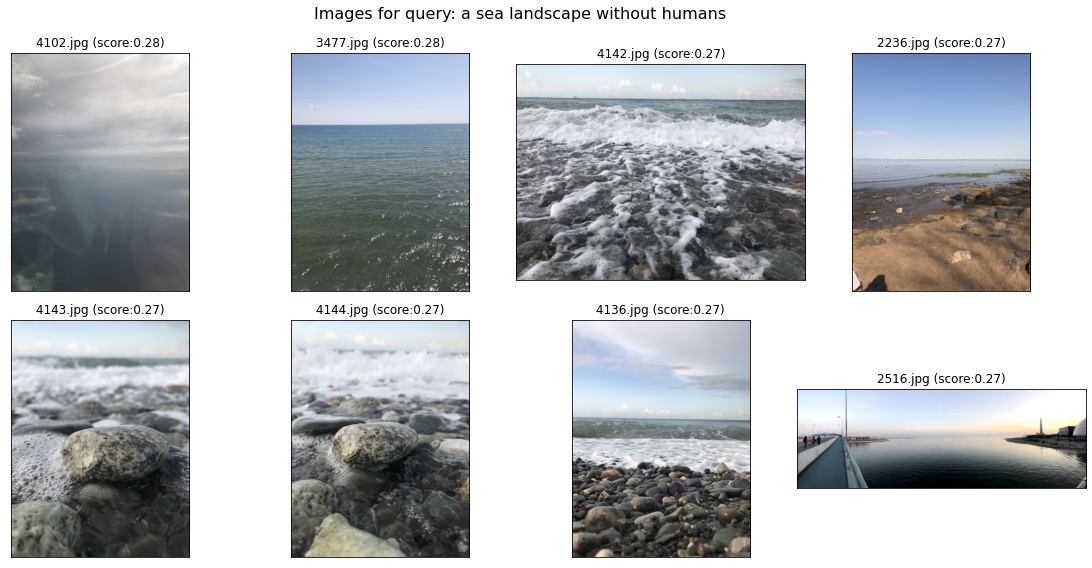

In [41]:
request = "a sea landscape without humans"
search_with_model(request, photo_features, 
                  photo_ids, results_count=RESULTS_COUNT, 
                  min_similarity=0.26, download=True)

Founded 30 images with more than 0.27 score


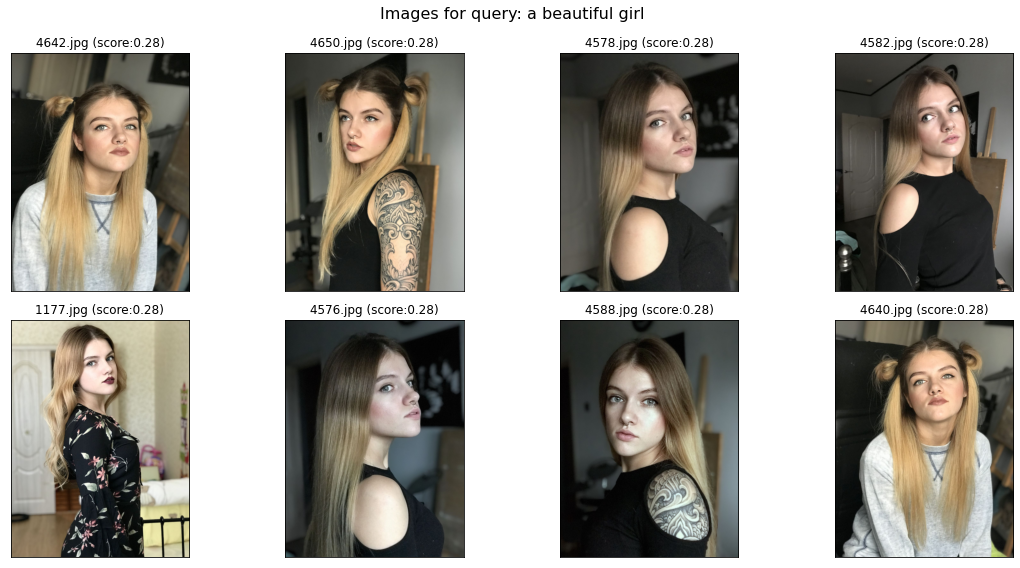

In [25]:
request = "a beautiful girl"
search_with_model(request, photo_features, 
                  photo_ids, results_count=RESULTS_COUNT, 
                  min_similarity=0.27, download=False)

Founded 47 images with more than 0.28 score


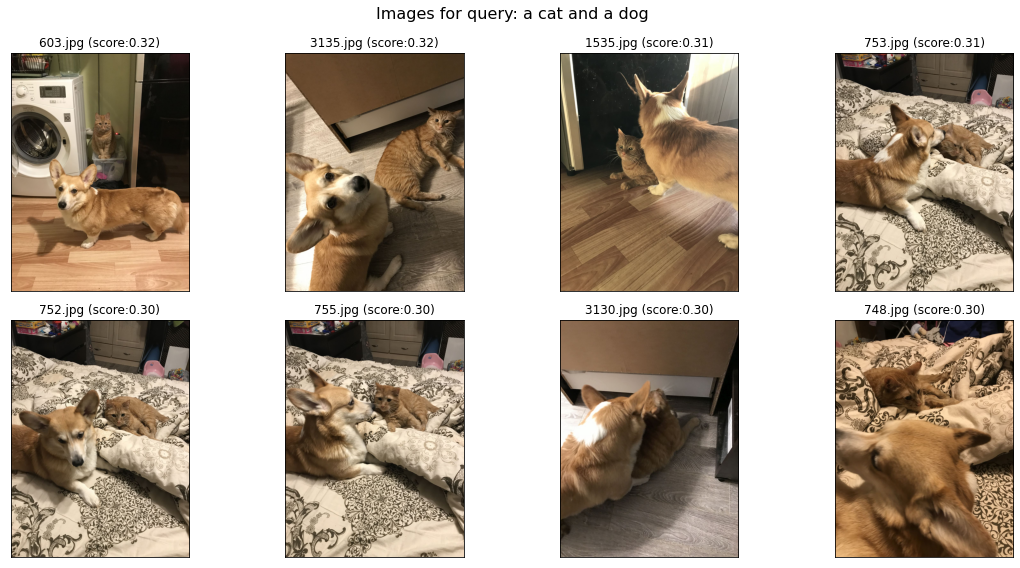

In [27]:
request = "a cat and a dog"
search_with_model(request, photo_features, 
                  photo_ids, results_count=RESULTS_COUNT, 
                  min_similarity=0.28, download=False)

Founded 100 images with more than 0.26 score


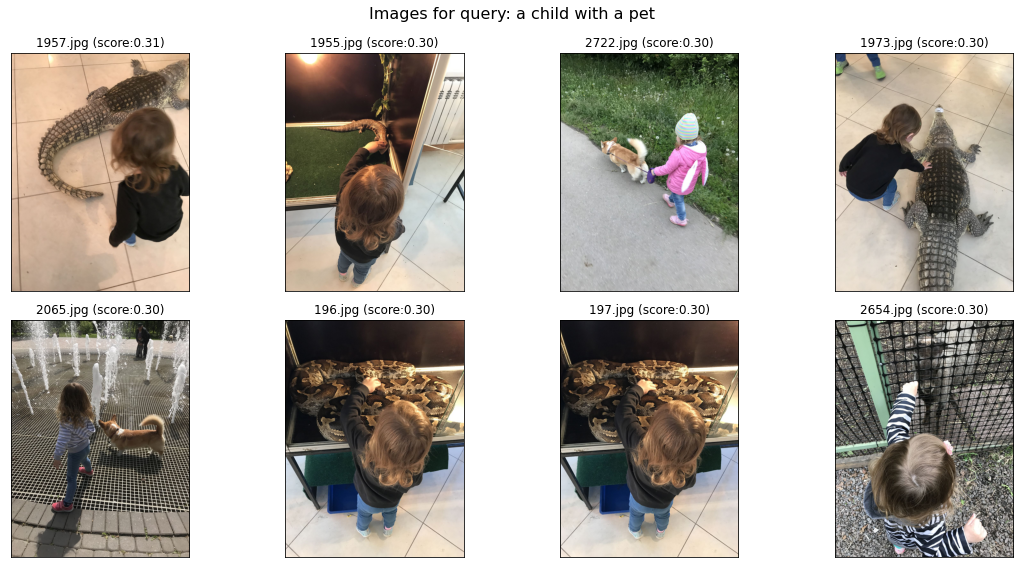

In [31]:
request = "a child with a pet"
search_with_model(request, photo_features, 
                  photo_ids, results_count=RESULTS_COUNT, 
                  min_similarity=0.26, download=False)

Founded 18 images with more than 0.26 score


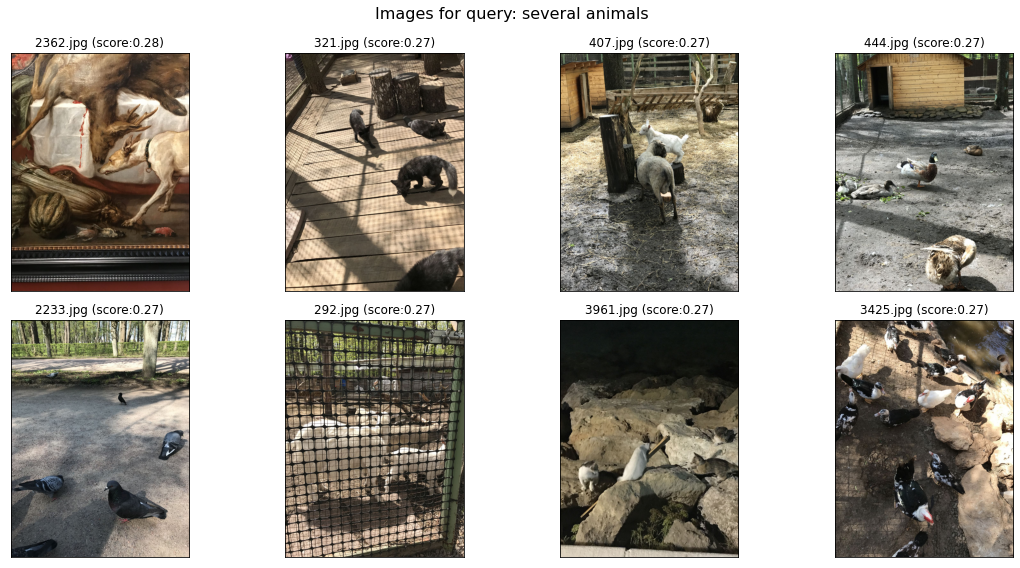

In [32]:
request = "several animals"
search_with_model(request, photo_features, 
                  photo_ids, results_count=RESULTS_COUNT, 
                  min_similarity=0.26, download=False)

Founded 12 images with more than 0.25 score


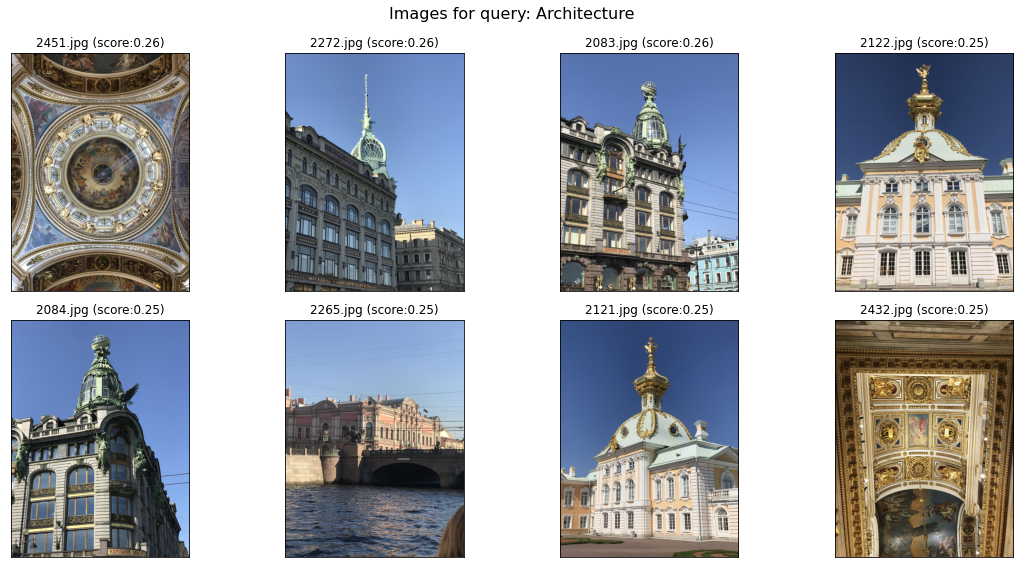

In [35]:
request = "Architecture"
search_with_model(request, photo_features, 
                  photo_ids, results_count=RESULTS_COUNT, 
                  min_similarity=0.25, download=False)

Founded 46 images with more than 0.25 score


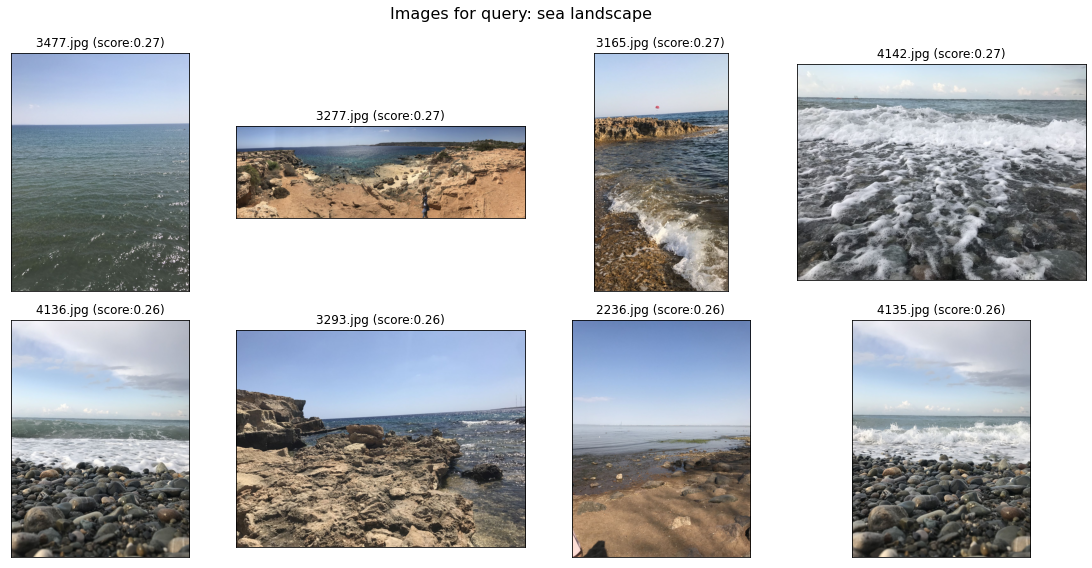

In [40]:
request = "sea landscape"
search_with_model(request, photo_features, 
                  photo_ids, results_count=RESULTS_COUNT, 
                  min_similarity=0.25, download=False)

Founded 76 images with more than 0.26 score


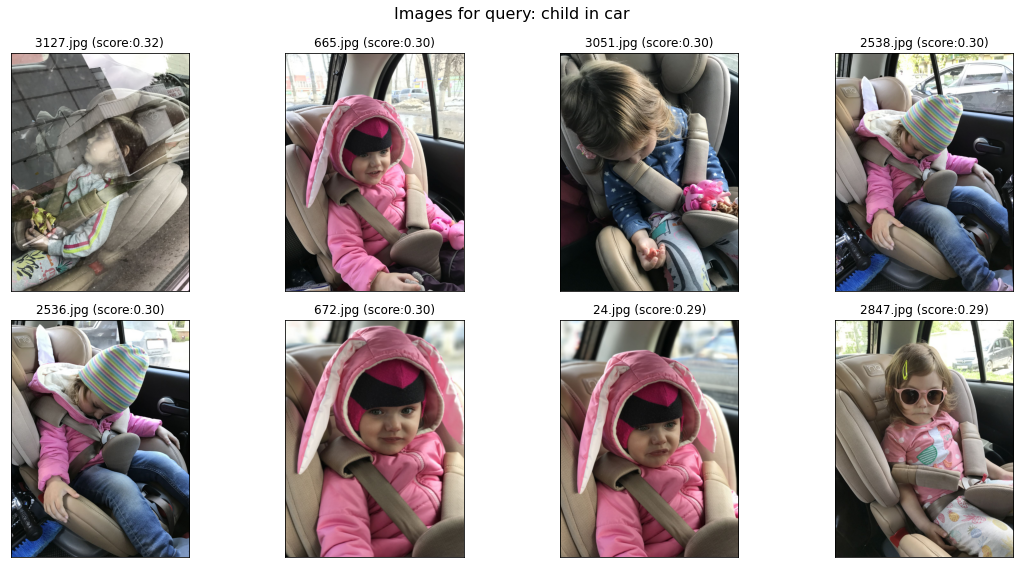

In [64]:
request = "child in car"
search_with_model(request, photo_features, 
                  photo_ids, results_count=RESULTS_COUNT, 
                  min_similarity=0.26, download=False)